## Ayagari Stationary Distribution
We solve for a stationary distribution to a Ayagari economy.

#### Preliminaries

In [1]:
## load some packages
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy import sparse
import numba as nb
import numpy as np

## config
# params
ALPHA = 1/3
BETA = 0.98
GAMMA = 2.
DELTA = 0.01
A_MIN = 0.  # borrowing constraint
ENDOWMENT = np.array([1, 2.5])  # low and high productivity
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix

# grids
A_MAX = 500
N_A = 501
GRID = np.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
We want to generalize our EGM function to a production economy. Instead of getting an endowment, households will endogenously switch between having low and high productivity, given by $z$. Therefore, the budget becomes
$$
    a' + c = R a + W z
$$
and the household solves
$$
    V(a, z) = \max_{a' \geq \underline a} \frac{\left(R a + W z - a'\right)^{1-\gamma}}{1-\gamma} + \beta \mathbb{E} V(a', z').
$$
Therefore, the household still has the Euler Equation
$$
    c^{-\gamma} = \beta R \mathbb{E} c^{\prime -\gamma}.
$$

Production takes place within a representative, competitive firm with production function
$$
    Y = K^\alpha L^{1-\alpha}.
$$

The FOCs of the production function and the depreciation rate for capital get the equations
\begin{align*}
    R &= \alpha K^{\alpha-1} L^{1-\alpha} + 1 - \delta \\
    W &= (1-\alpha) K^\alpha L^{-\alpha}
\end{align*}

Aggregates are defined so that
\begin{align*}
    K = \int_0^1 a di \\
    L = \int_0^1 z di.
\end{align*}

The solution to this model will be aggregates $\{K, L\}$, prices $\{R, W\}$, production $Y$, and a policy rule $g$ such that the distribution of households $\Gamma(a, z)$ stays constant between periods.

| Variable | Meaning |
| --- | --- |
| $c$ | 1 households consumption |
| $k$ | 1 households capital holdings |
| $z$ | 1 households labor efficiency |
| $K$ | Capital stock |
| $R$ | Rental rate of capital |
| $W$ | Wage per labor efficiency unit |
| $Y$ | Total output |

| Parameter | Meaning |
| --- | --- |
| $\alpha$ | Cobb-Douglas production parameter |
| $\beta$ | Discount rate |
| $\gamma$ | Risk aversion |
| $\delta$ | Capital depreciation rate |
| $\underline a$ | Borrowing constraint |

#### Labor
In the model, the labor supply is unaffected by the choices agents make and only by the exogenous shocks. This means we can solve for aggregate labor output using only the exogenous variables. To do this, we'll find the eigenvector of the transition matrix.

In [2]:
# get distribution
vals, vecs = np.linalg.eig(TRAN_MAT)
i = np.abs(vals).argmax()  # dominant eigenvactor
L_dist = vecs[:, i]
L_dist /= L_dist.sum()

# aggregate
L = ENDOWMENT @ L_dist

L

2.1250000000000004

#### Economy
Once we have $L$, all the prices and aggregate output can be solved for using just capital. We'll use the equations defining $W$, $R$, ang $Y$ to simplify how we set up the economy.

In [3]:
@nb.njit
def get_aggs(K, L=L):
    '''
    Solve for W, R, and Y given a capital value
    '''
    R = ALPHA * K**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
    W = (1-ALPHA) * K**ALPHA * L**(-ALPHA)
    Y = K**ALPHA * L**(1-ALPHA)

    return R, W, Y

R, W, Y = get_aggs(10)  # compile jit stuff

#### EGM
To solve for the policy function at a given level of capital, we'll implement the endogenous grid method.

In [4]:
@nb.njit
def linear_interpolation(x, y, X):
    '''
    Performs a linear interpolation of x and y at X
    '''
    # setuo
    n = len(x)

    # create and return interpolation
    idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
    x_l = x[idx-1]  # values below the x
    y_l = y[idx-1]
    x_h = x[idx]  # values above the x
    y_h = y[idx]
    m = (y_h - y_l) / (x_h - x_l)  # slope
    return y_l + m * (X - x_l)  

@nb.njit
def g_interp(a, a_t, a_p=GRID):
    '''
    Savings function for a given a_t maps to a_p
    '''
    # setup
    num_endows = a_t.shape[1]

    # interpolate
    a_pr = np.empty(a_t.shape)
    for i in nb.prange(num_endows):
        a_pr[:, i] = linear_interpolation(a_t[:, i], a_p, a)
    
    # borrowing constraint
    for i in nb.prange(a_pr.shape[0]):
        for j in nb.prange(a_pr.shape[1]):
            if a_pr[i, j] < A_MIN:
                a_pr[i, j] = A_MIN
    
    return a_pr

@nb.njit
def euler_back(a_t, R, W, a_p=GRID):
    '''
    Finds a savings function given a old guess for a savings function
    and gridpoitns
    '''
    c_p = R * a_p[:, None] + W * ENDOWMENT - g_interp(a_p, a_t)  # get next period consumption
    expec_dc_p = c_p ** (-GAMMA) @ TRAN_MAT  # take expectation with deriavtive
    c_t = (BETA * R * expec_dc_p)**(-1/GAMMA)  # consumption now
    a_t = 1/R * (a_p[:, None] + c_t - W * ENDOWMENT)  # savings at the start of the period

    return a_t

@nb.njit
def egm(a_t, R, W, max_iter=10000, tol=1e-14):
    for _ in range(max_iter):
        # get new consumption function
        last_a_t = a_t
        a_t = euler_back(a_t, R, W)

        # exit condition
        diff = np.abs(a_t - last_a_t).max()
        if diff < tol:
            break
    else:
        print('Policy Rule: Max iteration count exceeded')
    
    return a_t

a_t = 10 + 0.1 * np.tile(GRID, ENDOWMENT.shape+(1,)).T  # assumed policy function is that you save this amount from each point in the tiled grid
a_t = egm(a_t, R, W, max_iter=1)  # compile jit stuff

Policy Rule: Max iteration count exceeded


#### Distribution
To make this into a wealth distribution, we'll create a transition matrix for wealth and find the eigenvector.

In [5]:
@nb.njit
def make_tran_mat(a_p, a_t=GRID, exog_tran_mat=TRAN_MAT):
    '''
    Makes the wealth distribution transition matrix givena savings rule
    from each of the gridpoints. Returns the data, row, and column matricies
    to make a sparse matrix for it, not the matrix itself
    '''
    # figure out where values go
    idxs = np.minimum(np.searchsorted(a_t, a_p, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.empty(a_p.shape)
    for i in nb.prange(idxs.shape[0]):
        for j in nb.prange(idxs.shape[1]):
            idx = idxs[i, j]
            p_l[i, j] = max((a_t[idx] - a_p[i, j]) / (a_t[idx] - a_t[idx-1]), 0.)
    # # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low efficiency: capital now -> capital later
    data_l = np.concatenate((p_l[:, 0], p_h[:, 0]))
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = np.concatenate((idxs[:, 0]-1, idxs[:, 0]))[mask_l]
    col_l = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_l]

    # high efficicency: capital now -> capital later
    data_h = np.concatenate((p_l[:, 1], p_h[:, 1]))
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = np.concatenate((idxs[:, 1]-1, idxs[:, 1]))[mask_h]
    col_h = np.concatenate((np.arange(N_A), np.arange(N_A)))[mask_h]

    # create overall transition matrix
    data = np.concatenate((
            data_l * exog_tran_mat[0, 0], data_l * exog_tran_mat[1, 0],
            data_h * exog_tran_mat[0, 1], data_h * exog_tran_mat[1, 1],
        ))
    row = np.concatenate((
            row_l, N_A + row_l,  # top vector (employed) is on top
            row_h, N_A + row_h,
        ))
    col = np.concatenate((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    
    return data, row, col


def get_dist(a_p, a_t=GRID, exog_tran_mat=TRAN_MAT):
    '''
    Use the eignevector of a sparse matrix to find the stationary distribution
    of capital
    '''
    # get transition matrix
    data, row, col = make_tran_mat(a_p, a_t=a_t, exog_tran_mat=exog_tran_mat)
    tran_mat = sparse.csr_array((data, (row, col)), shape=(2*N_A, 2*N_A))

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    return dist

dist = get_dist(g_interp(GRID, a_t))  # compile jit stuff

#### Total Capital
Use the distribution to calculate total capital.

In [6]:
@nb.jit
def agg_K(dist, grid=GRID):
    return (grid * dist.T).sum()

_ = agg_K(dist)  # compile jit stuff

#### Full Implementation
Each iteration we
1. Use the guess for $K$ to find the prices in the economy
2. Use the prices to run an EGM to get a policy rule
3. Create a transition matrix and calculate a stationary distribution based on our policy rule
4. Aggregate $K$ to compare it to our intial guess

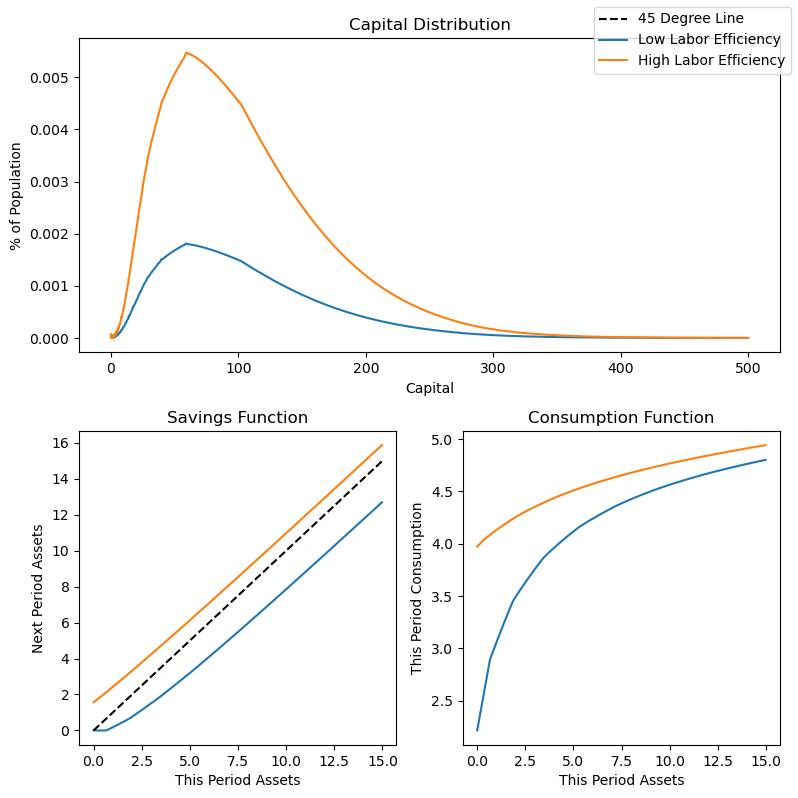

In [7]:
a_t0 = 10 + 0.1 * np.tile(GRID, ENDOWMENT.shape+(1,)).T
def simulate_economy(K, grid=GRID, a_t0=a_t0):
    R, W, Y = get_aggs(K)  # aggregate variables
    a_t = egm(a_t0, R, W)  # use the egm to solve for a policy rule
    a_t0[:] = a_t  # make next iteration faster
    dist = get_dist(g_interp(grid, a_t))  # get the distribution of capital
    K_d = agg_K(dist)

    return K_d, R, W, Y, a_t, dist

# params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-10  # actual capital will be within this distance of capital

# find equalibrium
K_rbc = ((1/BETA + DELTA - 1) / ALPHA / L**(1-ALPHA))**(1/(ALPHA-1))  # steady state RBC K
K = brentq(lambda K: simulate_economy(K)[0] - K, K_rbc, K_rbc+2., xtol=capital_tol, maxiter=capital_max_iter)
_, R, W, Y, a_t, dist = simulate_economy(K)  # get the economic variables
g = lambda a: g_interp(a, a_t)
c = lambda a: R*a[:, None] + W*ENDOWMENT - g(a)

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(GRID, dist[:, 0], label='Low Labor Efficiency')
axtop.plot(GRID, dist[:, 1], label='High Labor Efficiency')
n = (GRID < 15).sum()  # look at first n gridpoits, most the interesting stuff happens early
axs[1, 0].plot(GRID[:n], g(GRID)[:n])
axs[1, 0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], c(GRID)[:n])

# final things
fig.legend()
fig.tight_layout()